<a href="https://colab.research.google.com/github/belisards/unhcr_sites/blob/main/unhcr_locations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNHCR geodata extractor

This notebook aims to facilitate the work with geodata and satellite imagery for survey sampling in UNHCR camps.

Ideally, choose a Runtime with GPU (e.g. A100) in the menu ``Runtime`` > ``Change runtime type``.

**Features**

- Automated data extraction from the UNHCR Geoservices API

- Download of satellite imagery from Tile Map Services

- Filter for the Google Open Building geodata

**How to download the data**

Follow the instructions below and use the file manager in the left menu (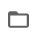). Then, navigate to the ``data`` folder, right-click on the file and choose the download option.


# UNHCR data

Use the left-sided "play" button to run the cells below, starting with the "Load the required packages" section.


In [5]:
# @title Load the required packages
%%capture
%pip install -q leafmap segment-geospatial shapely pygeos pyarrow pyogrio

from samgeo import tms_to_geotiff, get_basemaps

from tqdm import tqdm
tqdm.pandas()

import requests
import json, os, gzip, shutil

import geopandas as gpd
from shapely import speedups
from shapely.geometry import MultiPolygon, Polygon, shape
from shapely.wkt import loads

speedups.enable()

import ipywidgets as widgets
from IPython.display import display, clear_output

print("Packages loaded!")

Run the cell and use the input selector to choose a country.

Optionally, you can adjust the buffer size that will be used to generate polygons for locations represented as points.

In [6]:
#@title Select a country (run the cells before using the input selectors below)

#### Country selector
BASE_URL = "https://gis.unhcr.org/arcgis/rest/services/core_v2/"
COMMON_PARAMS = {'f': 'geojson'}
session = requests.Session()
EXPORT_FOLDER = "data"

def setup_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

# Setup folder
setup_folder(EXPORT_FOLDER)


def list_countries():
    params = {**COMMON_PARAMS, 'where': "1=1", 'outFields':'*', 'returnGeometry':'false'}
    try:
        response = session.get(BASE_URL+"wrl_prp_a_unhcr/FeatureServer/0/query", params=params)
        response.raise_for_status()
        data = response.json()
        site_codes = [item["properties"]["site_code"][:3] for item in data.get("features", [])]
        country_codes = list(set(site_codes))
        # sort alphabetically
        country_codes = sorted(country_codes)
        return country_codes
    except requests.RequestException as e:
        print(f"Failed to fetch data: {e}")
        return []

def save_geojson_with_metadata(country_code, geojson_data, output_file):
    # Add metadata to the geojson data
    metadata = {"country_code": country_code}
    geojson_data["metadata"] = metadata
    num_features = len(geojson_data.get("features", []))
    # Save to file
    with open(output_file, 'w') as f:
        json.dump(geojson_data, f, indent=4)
    print(f"GeoJSON data  with {num_features} features saved to {output_file}")

def extract_site_codes(country_data):
    results = [item["properties"]["site_code"] for item in country_data.get("features", [])]
    print(f"Successfully extracted {len(results)} official polygons")
    return results

def query_points(country_code, site_codes):
    # Wrap all site_codes with single quotes
    site_codes = [f"'{code}'" for code in site_codes]

    where_clause = f"iso3='{country_code}' AND pcode NOT IN ({','.join(site_codes)})"
    ## where_clause = f"iso3='{country_code}'"

    url = f"{BASE_URL}wrl_prp_p_unhcr_PoC/FeatureServer/0/query"

    params = {
        'where': where_clause,
        'outFields': 'pcode,gis_name',
        'f': 'geojson',
        'returnGeometry': 'true'
    }

    try:
        response = session.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        if data["features"]:
            for feature in data["features"]:
                feature['properties']['prefixed_gis_name'] = f"POINT_{feature['properties']['gis_name']}"
            print(f"Successfully fetched {len(data.get('features', []))} points")
            return data
        print(f"Successfully fetched {len(data.get('features', []))} points")
        #return data
    except requests.RequestException as e:
        print(f"Failed to fetch data: {e}")
        return {}


def query_polygons(country_code):
    params = {
        'where': f"site_code LIKE '{country_code}%'",
        'outFields': 'site_code, name',
        'f': 'geojson',
        'returnGeometry': 'true',
        'geometryType': 'esriGeometryPolygon',
        'outSR': 4326,
    }
    try:
        response = session.get(BASE_URL+"wrl_prp_a_unhcr/FeatureServer/0/query", params=params)
        response.raise_for_status()
        data = response.json()
        if data["features"]:
            for feature in data["features"]:
                feature['properties']['prefixed_gis_name'] = f"POLY_{feature['properties']['name']}"
            return data
        else:
            print(f"No data found for {country_code}")
            return {}
    except requests.RequestException as e:
        print(f"Failed to fetch data: {e}")
        return {}



def generate_square_buffer(point, buffer_size=0.03):
    """
    Generates a square buffer around a point.

    :param point: A tuple representing the (longitude, latitude) of the point.
    :param buffer_size: The size of the buffer (half the length of one side of the square).
    :return: A list of coordinates representing the square polygon.
    """
    lon, lat = point

    # Calculate the coordinates of the square's corners
    square_coords = [
        [lon - buffer_size, lat - buffer_size],  # Bottom-left
        [lon + buffer_size, lat - buffer_size],  # Bottom-right
        [lon + buffer_size, lat + buffer_size],  # Top-right
        [lon - buffer_size, lat + buffer_size],  # Top-left
        [lon - buffer_size, lat - buffer_size]   # Close the square (same as bottom-left)
    ]

    return square_coords

def gen_polygons(data, buffer_size=0.01):
    """
    Generates square polygons for each feature in the geojson-like data.

    :param data: The input data containing features with geometry of type 'Point'.
    :param buffer_size: The size of the buffer (half the length of one side of the square).
    :return: A GeoJSON-like structure with square polygons around each point.
    """
    features = data.get('features', [])

    square_features = []
    for feature in features:
        point_coords = feature['geometry']['coordinates']
        square_buffer = generate_square_buffer(point_coords, buffer_size)

        # Create a new feature with the square polygon
        square_feature = {
            'type': 'Feature',
            'geometry': {
                'type': 'Polygon',
                'coordinates': [square_buffer]
            },
            'properties': feature['properties']
        }

        square_features.append(square_feature)

    # Create a new GeoJSON FeatureCollection
    square_geojson = {
        'type': 'FeatureCollection',
        'features': square_features
    }
    assert len(square_geojson['features']) == len(features)
    return square_geojson


def process_country(country_code, buffer_size):
    official_polygons = query_polygons(country_code)
    if not official_polygons:
        print("No data found for the country")
        return None

    site_codes = extract_site_codes(official_polygons)
    points_data = query_points(country_code, site_codes)
    if not points_data:
        print("No points data found")
        return site_codes
    else:
        generated_polygons = gen_polygons(points_data, buffer_size)
        country_polygons = official_polygons["features"] + generated_polygons["features"]
        return {"type": "FeatureCollection", "features": country_polygons}


# Function to process the selected country and buffer size
def on_country_selected(change):
    clear_output(wait=True)
    display(country_selector)
    display(buffer_size_slider)
    country_code = country_selector.value
    buffer_size = buffer_size_slider.value
    print("---")
    print(f"Processing country: {country_code} with buffer size: {buffer_size}")
    country_data = process_country(country_code, buffer_size)
    if country_data:
        output_file = f"{EXPORT_FOLDER}/{country_code}_polygons.geojson"
        save_geojson_with_metadata(country_code, country_data, output_file)
        # save the output_file as a global variable
        global output_file_global
        output_file_global = output_file
    else:
        print("No data found for the country")


# Get the list of countries
country_list = list_countries()

# Create a dropdown widget for country selection
country_selector = widgets.Dropdown(
    options=country_list,
    description='Country:',
    value=None,
    disabled=False,
)

# Create a slider widget for buffer size
buffer_size_slider = widgets.FloatSlider(
    value=0.01,
    min=0.001,
    max=0.1,
    step=0.001,
    description='Buffer size',
    readout_format='.3f',
    continuous_update=False
)

# Attach the event handler to the dropdown
country_selector.observe(on_country_selected, names='value')

# Display the dropdown and slider widgets
display(country_selector)
display("Optional: select a buffer size to generate polygons from points")
display(buffer_size_slider)


Dropdown(description='Country:', index=7, options=('AFG', 'AGO', 'BDI', 'BFA', 'BGD', 'BWA', 'CAF', 'CMR', 'CO…

FloatSlider(value=0.01, continuous_update=False, description='Buffer size', max=0.1, min=0.001, readout_format…

---
Processing country: CMR with buffer size: 0.01
Successfully extracted 8 official polygons
Successfully fetched 325 points
GeoJSON data  with 333 features saved to data/CMR_polygons.geojson


After selecting a country above, choose one of the camps.

Make sure to run the cell to load the camps in the selected country.

In [11]:
#@title Select a camp
import leafmap
def extract_bbox(geometry):
    """
    Extracts the bounding box of a Polygon or MultiPolygon geometry.

    Args:
        geometry: A Polygon or MultiPolygon geometry.

    Returns:
        A list representing the bounding box [min_x, min_y, max_x, max_y].
    """
    # If it's a MultiPolygon, extract the first polygon
    if isinstance(geometry, MultiPolygon):
        geometry = geometry.geoms[0]  # Take the first polygon in the multipolygon

    # Now that we have a single Polygon, calculate the bounding box
    bbox = geometry.bounds
    return [bbox[0], bbox[1], bbox[2], bbox[3]]


def extract_centroid(geometry):
    """
    Extracts the centroid of a Polygon or MultiPolygon geometry.

    Args:
        geometry: A Polygon or MultiPolygon geometry.

    Returns:
        A tuple representing the (longitude, latitude) of the centroid.
    """
    # If it's a MultiPolygon, extract the first polygon
    if isinstance(geometry, MultiPolygon):
        geometry = geometry.geoms[0]  # Take the first polygon in the multipolygon

    # Now that we have a single Polygon, calculate the centroid
    centroid = geometry.centroid
    return centroid.x, centroid.y


def on_site_selected(change):
    clear_output(wait=True)
    display(site_selector)
    site_name = change['new']
    site_geometry = gdf[gdf['prefixed_gis_name'] == site_name]['geometry'].iloc[0]
    # print(site_geometry)
    global centroid
    centroid = extract_centroid(site_geometry)
    bbox = extract_bbox(site_geometry)
    # print("Centroid:", centroid)
    # print("Bounding Box:", bbox)

    # Plot on a map
    m = leafmap.Map(basemap="Google Satellite")
    # Add the geometry to the map
    m.add_gdf(gdf[gdf['prefixed_gis_name'] == site_name], layer_name=site_name)
    # Set the map center to the centroid
    m.set_center(centroid[0], centroid[1], 12)
    display(m)

gdf = gpd.read_file(output_file_global)
gdf['prefixed_gis_name'] = gdf['prefixed_gis_name'].fillna(gdf['name'])

site_names = gdf['prefixed_gis_name'].tolist()

site_names = sorted(site_names)

site_selector = widgets.Dropdown(
    options=site_names,
    description='Site:',
    # value=site_names[0],
    value=None,
    disabled=False,
)
display(site_selector)

site_selector.observe(on_site_selected, names='value')

Dropdown(description='Site:', index=327, options=('POINT_AFADE', 'POINT_AMADABO', 'POINT_ASSIGHASSIA', 'POINT_…

Map(center=[4.278474431410762, 14.913164746272376], controls=(ZoomControl(options=['position', 'zoom_in_text',…


After selecting a location, execute the cell below.

You can change code and set the ``verbose`` option to ``True`` if you want to get (a lot of) messages showing the download progress.

The file will be saved in our Google Colab data folder. Don't forget to download the file to your computer to store it permanently.



In [9]:
#@title Save the basemap in your temporary session

print("Saving the basemap file in your Google Colab session. This might take several (3 to 5) minutes.")
BASEMAP_FILE = "data/basemap.tiff"

# Extract bbox from the selected geometry
bbox = extract_bbox(gdf[gdf['prefixed_gis_name'] == site_selector.value]['geometry'].iloc[0])

# Download the basemap as a GeoTIFF file
tms_to_geotiff(output=BASEMAP_FILE, bbox=bbox, zoom=20, source="Satellite", overwrite=False, quiet=True)

clear_output(wait=True)
print(f"Basemap downloaded to {BASEMAP_FILE}. You need to use the file manager to download the file to your compute, otherwise it will be deleted after your session expires")


Saving the basemap file in your Google Colab session. This might take several (3 to 5) minutes.


KeyboardInterrupt: 

# Filtering the Google Open Buildings (GOB) dataset

First, you need to use this notebook to get the dataset for the country you selected: [https://colab.research.google.com/github/google-research/google-research/blob/master/building_detection/open_buildings_download_region_polygons.ipynb](https://colab.research.google.com/github/google-research/google-research/blob/master/building_detection/open_buildings_download_region_polygons.ipynb)

Upload the file to your Google Drive and execute the cell below to grant access and mount your Drive folders.


In [10]:
#@title Mount Google Drive

from google.colab import drive

GDRIVE_PATH = '/content/drive/'
drive.mount(GDRIVE_PATH)

print("Google Drive mounted successfully!")


Mounted at /content/drive/
Google Drive mounted successfully!


Use the file manager (the left-sided folder icon) to navigate in your Google Drive directories and find the GOB compressed file. Right-click and select the option ``Copy path``.

Paste the file path in the ``GZ_FILE`` variable and click on the button unpack the file. You only need to run this cell in your first execution of the pipeline, as files in your Google Drive folders do not expire.

In [22]:
#@title Optional: Change the GZ_FILE variable to unpack the file

GZ_FILE = "/content/drive/MyDrive/GOB_datasets/open_buildings_v3_polygons_ne_110m_CMR.csv.gz"

try:
  # Extract the directory path where the file is located
  dir_path = os.path.dirname(GZ_FILE)

  # Output file path without .gz
  csv_file = GZ_FILE.replace(".gz", "")

  # Uncompress the .gz file in its original folder using gzip
  with gzip.open(GZ_FILE, 'rb') as f_in:
      with open(csv_file, 'wb') as f_out:
          shutil.copyfileobj(f_in, f_out)

  print(f"File {csv_file} has been uncompressed.")

except:
  print("Error")

File /content/drive/MyDrive/GOB_datasets/open_buildings_v3_polygons_ne_110m_CMR.csv has been uncompressed.



Execute the cell below and check if the path to the uncompressed CSV file is correct. If you ran the cell above, the script will import the path to the uncompressed file.

Then, click on the button to load the dataset. This step might take several minutes.

In [23]:
#@title Load the GOB dataset

file_selector = widgets.Text(
    value=csv_file,
    description='CSV:',
    disabled=False
)

# Define a button
button = widgets.Button(description="Load CSV")

def load_df(b):
    print(f"Loading file {file_selector.value}.. You will not see the 'loading' icon in the cell, but hold on and wait the confirmation message.")
    global country_gob_all
    country_gob_all = gpd.read_file(file_selector.value,engine='pyogrio', use_arrow=True)
    print(f"File {file_selector.value} loaded.")

# Set the button to trigger the function when clicked
button.on_click(load_df)

# Display the selector and the button
display(file_selector)
display(button)


Text(value='/content/drive/MyDrive/GOB_datasets/open_buildings_v3_polygons_ne_110m_CMR.csv', description='CSV:…

Button(description='Load CSV', style=ButtonStyle())

Loading file /content/drive/MyDrive/GOB_datasets/open_buildings_v3_polygons_ne_110m_CMR.csv.. You will not see the 'loading' icon in the cell, but hold on and wait the confirmation message.
File /content/drive/MyDrive/GOB_datasets/open_buildings_v3_polygons_ne_110m_CMR.csv loaded.


In [ ]:

country_copy = country_gob_all.copy()
country_copy['geometry'] = country_copy['geometry'].apply(loads)

country_copy = gpd.GeoDataFrame(country_copy, geometry='geometry')

m = leafmap.Map(center=centroid, zoom=12)

m.add_gdf(country_copy, layer_name="GOB")

m


Execute the cell to calculate the intersection between both geodata files (camp location and GOB country dataset). This might take several minutes.

In [ ]:
#@title Export the intersection between the camp and the GOB dataset

# GOB
country_gob_all['geometry'] = country_gob_all['geometry'].apply(loads)

country_gob = gpd.GeoDataFrame(country_gob_all, geometry='geometry')

# UNHCR data
feature = gdf[gdf['prefixed_gis_name'] == site_selector.value]
polygon_gdf = gpd.GeoDataFrame(geometry=[shape(feature['geometry'].iloc[0])])

intersection = gpd.overlay(country_gob, polygon_gdf, how='intersection')

# Count n. of features
print(f"Number of GOB features in the polygon: {len(intersection)}")

# Export
export_file_name = "data/gob_" + site_selector.value + ".json"
intersection.to_file(export_file_name, driver="GeoJSON")
print(f"Intersection saved to: {export_file_name}")

Number of GOB features in the polygon: 3613
Intersection saved to: data/gob_POLY_Gado Badzere.json


You can visualize the GOB dataset filtered running the cell below.

In [ ]:
#@title Display the GOB features

centroid = extract_centroid(feature['geometry'].iloc[0])

style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.2,
}

m = leafmap.Map(basemap="Google Satellite")
# m.add_raster(BASEMAP_FILE, layer_name="Basemap",basemap="Google Satellite")
m.add_geojson(output_file_global, layer_name="Polygons")
m.add_gdf(intersection, layer_name="Intersection",style = style)
m.set_center(centroid[0],centroid[1],16)
m

Map(center=[4.278474431410762, 14.913164746272376], controls=(ZoomControl(options=['position', 'zoom_in_text',…

Execute this cell to save the HTML map.

In [ ]:
# @title Save the map as an HTML file
html_file = "data/map.html"
m.to_html(outfile=html_file)

Run the cell below to move the data folder to your Google Drive.

In [ ]:
#@title Move the data folder to your Google Drive
OUTPUT_FOLDER = GDRIVE_PATH + "MyDrive/UNHCR_geodata/"

# check if exists
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

!cp -r data/* {OUTPUT_FOLDER}

print(f"All files in the data folder have been moved to {OUTPUT_FOLDER}")


All files in the data folder have been moved to /content/drive/MyDrive/UNHCR_geodata/
